# Open Exercise

Select from a dataset generated through [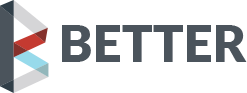](https://www.ec-better.eu/) and perform your own analysis, applying some of the techniques discussed before, or other techniques from your own choice.

* Amazon: CCD Products: Backscatter pre (band 0), post (band 1) and coherence (band 2) for fires detection and characterisation.

    Typical questions to answer:

    * [ ] When did the fire took place?

    * [ ] What are the areas affected and when?

    * [ ] What is the extension of the bunred area? And its evolution?

    * [ ] Can we validate it with external data sources? Can we correlate it with other indicators?

* CharPiya: Backscatter per date.

    Typical questions to answer:

    * [ ] When did the construction of the camp took place? Do you identify different phases in the construction?

    * [ ] What is the extension of the camp?

    * [ ] Was there any flooding event? When? Did it affect the camp?

    * [ ] Can you validate or reference certain events with ancillary data?


In [1]:
!/opt/anaconda/envs/env_better/bin/pip3 install folium shapely rasterio bs4 tqdm

     |████████████████████████████████| 115 kB 3.4 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=468d29dbd5e2015e8353f22a0e09a4ec6d974e5ec183977c28df7ec5197805ca
  Stored in directory: /home/jovyan/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [2]:
import rasterio
import rasterio.mask
import requests
import fiona

In [4]:
from bs4 import BeautifulSoup
import requests
from shapely.geometry import shape
from tqdm import tqdm

url_charpiya = 'https://store.terradue.com/nextgeoss-change-detection-s1/charpiya/'
url_amazon = 'https://store.terradue.com/nextgeoss-change-detection-s1/s1Burned/'
center_charpiya = [22.38, 91.4]

url = url_charpiya 
center = center_charpiya 

ext = 'tif'

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

vector_fn = 'data/InsideCharpiya.shp'

with fiona.open(vector_fn, 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

masked_images = list()
dates = list()

with tqdm(total=19) as pbar:
    for file in listFD(url, ext):
        dates.append(file)
        with rasterio.open(file) as src:
            masked_data, masked_transform = rasterio.mask.mask(src, shapes, crop=True) 
            masked_meta = src.meta
            bbox = shape(shapes[0]).bounds
            img = masked_data[0]
            masked_images.append(img)
            pbar.update(1)
            


100%|██████████| 19/19 [02:58<00:00,  9.42s/it]


In [5]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from helpers import *

fig, ax = plt.subplots(figsize=(10, 25))

def update(i):
    im_normed = convert2byte(masked_images[i-1],0,1)
    ax.imshow(im_normed, cmap='gray')
    ax.set_title("{}".format(dates[i].rsplit('/',1)[-1]), fontsize=12)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, 19), interval=500)
anim.save('test.gif', dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


In [6]:
%%html
<img src="test.gif" />